In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR
from sympy import sympify, symbols

In [3]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [2]:
class Multi_Func(nn.Module):
    def __init__(self, functions, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions  # [[function, (...)], [# params, (...)]]
        self.x_data = x_data
        self.input_channels = input_channels
        self.params = sum(self.functions[1])

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.params), 
        )

    def forward(self, x, n=-1):
        target = x.squeeze(dim=2)
        x = torch.swapaxes(x, 1, 2).to(self.device)
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        start_index = 0
        losses = []
        outputs = []
        target_range = torch.max(target, dim=-1, keepdim=True)[0] - torch.min(target, dim=-1, keepdim=True)[0]
        target_range = torch.clamp(target_range, min=1e-6)

        for f in range(len(self.functions[0])):
            output = self.functions[0][f](
                embedding[:, start_index:start_index+self.functions[1][f]], 
                self.x_data, 
                device=self.device
            ).to(self.device)
            outputs.append(output)
            loss = torch.mean(torch.abs(target - output) ** 3, dim=tuple(range(1, target.dim())))/target_range.squeeze(-1)
            losses.append(loss)
            start_index += self.functions[1][f]    
        
        stacked_outputs = torch.stack(outputs)
        stacked_losses = torch.stack(losses)
        best_losses, best_indexes = torch.min(stacked_losses, dim=0) 
        best_outs = stacked_outputs[best_indexes, -1]
        best_funcs = [self.functions[0][idx] for idx in best_indexes]

        return best_outs, best_losses, best_funcs, stacked_outputs, stacked_losses


In [3]:
import pandas as pd
df = pd.read_csv('FeynmanEquations.csv')

functions = []
num_vars_per_func = []

for _, row in df.iterrows():
    formula = row['Formula']
    num_vars = row['# variables']
    function_details = {
        'formula': formula,
        'variables': []
    }
    
    for i in range(1, 11):  
        v_name = row.get(f'v{i}_name', None)
        v_low = row.get(f'v{i}_low', None)
        v_high = row.get(f'v{i}_high', None)
        
        if pd.notna(v_name):
            function_details['variables'].append({
                'name': v_name,
                'low': v_low,
                'high': v_high
            })
    
    functions.append(function_details)
    num_vars_per_func.append(num_vars)

'''for i, func in enumerate(functions):
    print(f"Function {i+1}:")
    print(f"  Formula: {func['formula']}")
    print(f"  Number of Variables: {num_vars_per_func[i]}")
    print("  Variables:")
    for var in func['variables']:
        print(f"    - Name: {var['name']}, Range: ({var['low']}, {var['high']})")
    print()'''


'for i, func in enumerate(functions):\n    print(f"Function {i+1}:")\n    print(f"  Formula: {func[\'formula\']}")\n    print(f"  Number of Variables: {num_vars_per_func[i]}")\n    print("  Variables:")\n    for var in func[\'variables\']:\n        print(f"    - Name: {var[\'name\']}, Range: ({var[\'low\']}, {var[\'high\']})")\n    print()'

In [6]:
def generate_data(sample_size, num_vars, min, max, device):
    hold =[]
    for _ in range(num_vars):
        v = (max - min) * torch.rand(sample_size, 1, 1) + min
        hold.append(v)
    params = torch.stack(hold)
    params = torch.atleast_2d(params)
    params = torch.transpose(params, 0, 1)
    params = torch.transpose(params, 1, 2)
    params = params.to(device)
    return params


In [5]:
functions[8]["variables"]

[{'name': 'q1', 'low': 1, 'high': 5},
 {'name': 'q2', 'low': 1.0, 'high': 5.0},
 {'name': 'epsilon', 'low': 1.0, 'high': 5.0},
 {'name': 'r', 'low': 1.0, 'high': 5.0}]

In [6]:
def generate_function(function, sample_size, device):
    hold = []
    sympy_symbols = []
    
    for var in function["variables"]:
        sym = symbols(var["name"])
        sympy_symbols.append(sym)
        min_val = var["low"]
        max_val = var["high"]
        v = (max_val - min_val) * torch.rand(sample_size, 1, 1) + min_val
        hold.append(v)
    
    params = torch.stack(hold)
    params = torch.atleast_2d(params)
    params = torch.transpose(params, 0, 1)
    params = torch.transpose(params, 1, 2)
    params = params.to(device)

    formula = sympify(function["formula"])
    
    results = []
    for i in range(sample_size):
        var_values = {sympy_symbols[j]: params[i, 0, j].item() for j in range(len(sympy_symbols))}
        evaluated = formula.subs(var_values)
        results.append(float(evaluated))
    
    return results

In [7]:
sample_size = 100
hold = []
for f in functions:
    try:
        results = generate_function(f, sample_size, device)
        hold.append(results)
    except Exception as e:
        print(f"Error processing function {f}: {e}")
hold_t = [torch.tensor(l) for l in hold]
data = torch.stack(hold_t)
print(data.shape)


Error processing function {'formula': 'exp(-theta**2/2)/sqrt(2*pi)', 'variables': [{'name': 'theta', 'low': 1, 'high': 3}]}: name 'device' is not defined
Error processing function {'formula': 'exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)', 'variables': [{'name': 'sigma', 'low': 1, 'high': 3}, {'name': 'theta', 'low': 1.0, 'high': 3.0}]}: name 'device' is not defined
Error processing function {'formula': 'exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*sigma)', 'variables': [{'name': 'sigma', 'low': 1, 'high': 3}, {'name': 'theta', 'low': 1.0, 'high': 3.0}, {'name': 'theta1', 'low': 1.0, 'high': 3.0}]}: name 'device' is not defined
Error processing function {'formula': 'sqrt((x2-x1)**2+(y2-y1)**2)', 'variables': [{'name': 'x1', 'low': 1, 'high': 5}, {'name': 'x2', 'low': 1.0, 'high': 5.0}, {'name': 'y1', 'low': 1.0, 'high': 5.0}, {'name': 'y2', 'low': 1.0, 'high': 5.0}]}: name 'device' is not defined
Error processing function {'formula': 'G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)', 'varia

RuntimeError: stack expects a non-empty TensorList

torch.Size([100])


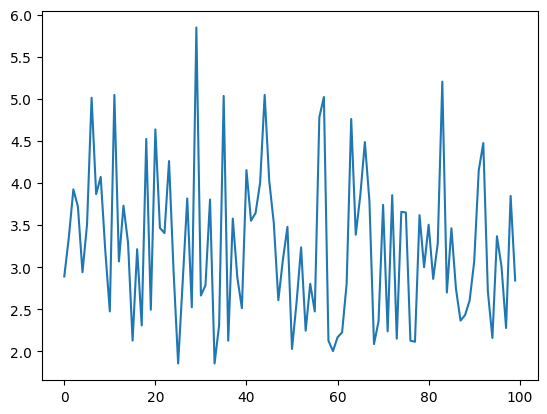

In [26]:
r = np.random.randint(data.shape[0])
print(data[r].shape)
plt.plot(data[r].detach().numpy())